# Agent
In prvious notebook, we've shown the workflow patterns. Here we focus on the agents, where they can plan, take actions (via tool-calling), and respond to feedback (in a loop).

## LLM Setup
For the following notebooks, we use LangGraph along Anthropic API.

In [4]:
# Required Modules

import sys
import os
import logging
import platform
from datetime import date, datetime

from dotenv import load_dotenv

from langchain_anthropic import ChatAnthropic
from pydantic import BaseModel, Field

# Modules used for prompt chaining
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


print(f"  System: {sys.platform}")
print(f"  Platform: {platform.platform()}")
print(f"  Python version: {platform.python_version()}")
print(f"  System Execution (Python) path: {'/'.join(sys.executable.strip('/').split('/')[-3:])}")
print(f"  Last update: {date.today().strftime('%Y-%m-%d')}")

  System: darwin
  Platform: macOS-15.4.1-arm64-arm-64bit
  Python version: 3.11.12
  System Execution (Python) path: .venv/bin/python
  Last update: 2025-05-19


In [5]:
# Configure logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [6]:
def _set_env(var: str):
    load_dotenv()  # Load variables from .env into os.environ
    if not os.environ.get(var):
        raise EnvironmentError(f"Environment variable '{var}' not found. Please set it in .env")
    else:
        logger.info(f"Environment variable '{var}' is loaded.")

# Load 
_set_env("ANTHROPIC_API_KEY")

model = "claude-3-5-sonnet-latest"
llm = ChatAnthropic(model=model)
logger.info(f"LLM model object is built wih '{model}'.")

2025-05-19 15:46:19,153 - __main__ - INFO - Environment variable 'ANTHROPIC_API_KEY' is loaded.
2025-05-19 15:46:19,154 - __main__ - INFO - LLM model object is built wih 'claude-3-5-sonnet-latest'.


# Routing
Agents plan, take actions (via tool-calling), and respond to feedback (in a loop).

- E.g., when solving open-ended problems that you cannot lay out as a workflow


<div style="text-align: center;">
   <img src="images/agent.webp" alt="Sample Image" width="50%">
</div>


## Example:

- An agent which is capable of peforming basic arithmetics via tool calling.

## Tool Definition & Binding
Each tool is a simple Python function wrapped with the ``@tool`` decorator to expose it for use by the LLM. In addition, the tools are made available to the LLM through ``bind_tools``, enabling the LLM to call them during reasoning steps.


In [7]:
from langchain_core.tools import tool

# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [8]:
from langgraph.graph import MessagesState
from langchain_core.messages import ToolMessage, SystemMessage, HumanMessage
from typing_extensions import Literal

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

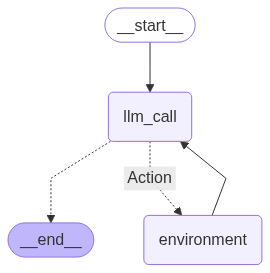

In [9]:
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [10]:
messages = [HumanMessage(content="Add 3 and 4. Then, take the output and multiple by 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()

2025-05-19 15:50:20,726 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 15:50:25,967 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"
2025-05-19 15:50:34,878 - httpx - INFO - HTTP Request: POST https://api.anthropic.com/v1/messages "HTTP/1.1 200 OK"


================================ Human Message =================================

Add 3 and 4. Then, take the output and multiple by 4.
================================== Ai Message ==================================

[{'text': "I'll help you with that calculation. Let's break it down into steps:\n\n1. First, let's add 3 and 4:", 'type': 'text'}, {'id': 'toolu_014tY4Pz55Qwmu5sYzNyCP5X', 'input': {'a': 3, 'b': 4}, 'name': 'add', 'type': 'tool_use'}]
Tool Calls:
  add (toolu_014tY4Pz55Qwmu5sYzNyCP5X)
 Call ID: toolu_014tY4Pz55Qwmu5sYzNyCP5X
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

[{'text': "2. Now, let's multiply the result (7) by 4:", 'type': 'text'}, {'id': 'toolu_01BxQsNHxfEof1wECURhYewE', 'input': {'a': 7, 'b': 4}, 'name': 'multiply', 'type': 'tool_use'}]
Tool Calls:
  multiply (toolu_01BxQsNHxfEof1wECURhYewE)
 Call ID: toolu_01BxQsNH